In [1]:
# Here we take care of paths.

from pathlib import Path
import os
print('Starting path:' + os.getcwd())
if os.getcwd()[-16:] == 'image-to-tex-OCR':
    pass
else:
    PATH = Path().resolve().parents[0]
    os.chdir(PATH)

# make sure you are in Paragraph_to_Tex folder
print('Current path:' + os.getcwd())

Starting path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR/Jupyter_Notebooks
Current path:/Users/gregory/PROJECT_ML/PROJECT_AMINE/image-to-tex-OCR


In [2]:
from Data.Data_Module import Data_Module
from Models.Printed_Tex_Transformer import ResNetTransformer
from Lightning_Models.Printed_Tex_Lit_Model import LitResNetTransformer
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from PIL import Image
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from torchvision import transforms
from PIL import Image
from IPython.display import display, Math
from Data.image_transforms import Image_Transforms
import cv2
import cv2
import PIL
import numpy as np
transform = transforms.ToPILImage()



dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


In [3]:
# Generate Data Module by uploading images and formulas
# images need to be in the folder Data/Data_Bank/generated_png_images
# formulas need to be in Data/Data_Bank/final_png_formulas.txt
# image filenames need to be in Data/Data_Bank/corresponding_png_images.txt

dataset = Data_Module(stage = 'fit',
                 set_max_label_length = 128,
                 number_png_images_to_use_in_dataset=250*1000,
                 labels_transform='default',
                image_transform_name ='alb',
                 train_val_fraction = 0.999,
                   vocabulary_path = 'Tokenizer/230k_ver2.json',
                load_vocabulary = True,
                      image_padding = True,
                      max_width = 10*1000,


                 batch_size = 128,
                num_workers = 8,
                data_on_gpu = True,
                )

In [4]:
print( 
    'Vocabulary size:',len(dataset.vocabulary),
    '\nMax label length:', dataset.max_label_length,
    "\nStart <S> goes to index ",dataset.vocabulary['<S>'],
      "\nEnd <E> goes to index ",dataset.vocabulary['<E>'],
      "\nPadding <P> goes to index ",dataset.vocabulary['<P>'],
)

Vocabulary size: 581 
Max label length: 130 
Start <S> goes to index  0 
End <E> goes to index  1 
Padding <P> goes to index  2


In [5]:


# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s

In [6]:
model = ResNetTransformer(dataset=dataset).to(dev)
# N_Inverted_128seq_1128Height_256embed_resnet34_4layers_8ratio_4
model.load_state_dict(torch.load(("Models_Parameters_Log/RESNET50_1.pth"), map_location=torch.device('cpu')))
lit_model = LitResNetTransformer(model=model, WandB=False)
lit_model.eval()
lit_model.freeze()
scripted_save = lit_model.to_torchscript()
torch.jit.save(scripted_save, "Models_Parameters_Log/scripted_model1.pt")


/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/Users/gregory/opt/anaconda3/lib/python3.9/site-packages/torch/jit/_recursive.py:262: UserWarning: 'batch_first' was found in ScriptModule constants, but was not actually set in __init__. Consider removing it.
  warnings.warn("'{}' was found in ScriptModule constants, "


In [7]:
scripted = torch.jit.load("Models_Parameters_Log/scripted_model1.pt")

In [8]:
import albumentations
from albumentations.augmentations.geometric.resize import Resize
import torch.nn.functional as F

MAX_RATIO = 8
GOAL_HEIGHT = 128

def find_ratio(h, w, goal):
    return goal/h
    


def predict(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    #image = cv2.bitwise_not(image)
    h, w, c = image.shape
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))



def predict_inverted(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    image = cv2.bitwise_not(image)
    
    ratio =w / h
    if ratio == 0:
        ratio = 1 
    if ratio > MAX_RATIO:
        ratio = MAX_RATIO
        
    
    new_h = GOAL_HEIGHT
    new_w = int(new_h * ratio)
    image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    print(display(transform(image_tensor)))
    
    max_H = 128
    max_W = 1024

    image_tensor = F.pad(image_tensor, (0, max_W - new_w, 0, max_H - new_h), value=0)

    
    print(image_tensor.shape)
    print(display(transform(image_tensor)))
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
def predict_simple(image_path):
   
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    #ratio =w / h
    #if ratio == 0:
        #ratio = 1 
    #if ratio > MAX_RATIO:
        #ratio = MAX_RATIO
        ##new_h = GOAL_HEIGHT
        #new_w = int(new_h * ratio)
        #image = Resize(interpolation= cv2.INTER_LINEAR,height=new_h, width= new_w, always_apply=True)(image=image)['image']
    
    print(image.shape)


    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image']#[:1]
    print(display(transform(image_tensor)))
    
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
    
    
    
    
def predict_scaled(image_path):
    image = Image.open(image_path).convert('RGB')
    image = np.asarray(image)
    h, w, c = image.shape
    ascpect = w/h
    if ascpect == 0:
        ascpect = 1 
    if ascpect > MAX_RATIO:
        ascpect = MAX_RATIO
    
    downscale = GOAL_HEIGHT/h
    image = cv2.resize(image, (0,0), fx=downscale, fy=downscale,interpolation=cv2.INTER_LINEAR)
   
    print(image.shape)
    



    
    image_tensor = Image_Transforms.test_transform_with_padding(image =np.array(image))['image'][:1]
    max_H = 128
    max_W = 1024

    if h<128 and w<1024:
        image_tensor = F.pad(image_tensor, (0, max_W - w, 0, max_H - h), value=0)

    print(display(transform(image_tensor)))
    print(image_tensor.shape)
    print('\nPredicted formula:')
    prediction =  scripted(image_tensor.unsqueeze(0))
    print(token_to_strings(prediction))
    print(display(Math(token_to_strings(prediction))))

    
# HELPER FUNCTIONS
def token_to_strings(tokens):
    mapping = dataset.vocabulary
    inverse_mapping =dataset.inverse_vocabulary
    s=''
    if tokens.shape[0] ==1:
        tokens = tokens[0]
    for number in tokens:
        letter = inverse_mapping[number.item()]
        s= s +" " + str(letter)
    return s
    

In [9]:
IMAGES= [#'Jupyter_Notebooks/test_photos/79a37d9d8b727e9.png',
         #"Jupyter_Notebooks/test_photos/S201.png",
          #"Jupyter_Notebooks/test_photos/202.png",
           "Jupyter_Notebooks/test_photos/203.png",
         "Jupyter_Notebooks/test_photos/qqq.png",
         "Jupyter_Notebooks/test_photos/zarhin.png",
         "Jupyter_Notebooks/test_photos/my_image.png",
         "Jupyter_Notebooks/test_photos/screenshot_1.png",
         "Jupyter_Notebooks/test_photos/screenshot_3.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_14.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_10.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_13.png",
          "Jupyter_Notebooks/test_photos/Screen Shot_11.png",
         "Jupyter_Notebooks/test_photos/screenshot_2.png",
         "Jupyter_Notebooks/test_photos/Screen Shot_18.png",
        'Jupyter_Notebooks/test_photos/128.png',
         'Jupyter_Notebooks/test_photos/128_2.png',
         'Jupyter_Notebooks/test_photos/image_3.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_15.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_11.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_16.png',
         'Jupyter_Notebooks/test_photos/Screen Shot_17.png',
         'Jupyter_Notebooks/test_photos/screenshot_2.png',
         'Jupyter_Notebooks/test_photos/ratio25.png',
         'Jupyter_Notebooks/test_photos/ratio31.png',
        'Jupyter_Notebooks/test_photos/ratio76.png',
         
    

]

(128, 380, 3)


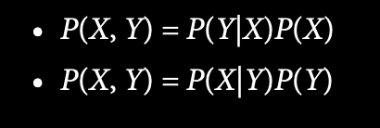

None
torch.Size([1, 128, 1024])


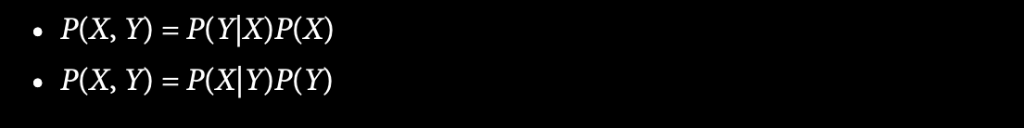

None

Predicted formula:
 <S> \begin{array} { l l l } { \sim p ( X , Y ) = p ( Y ) X p ( Y ) } \\ { \cdot P ( X , Y ) = P ( X ) P ( Y ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 555, 3)


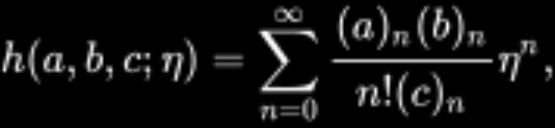

None
torch.Size([1, 128, 1024])


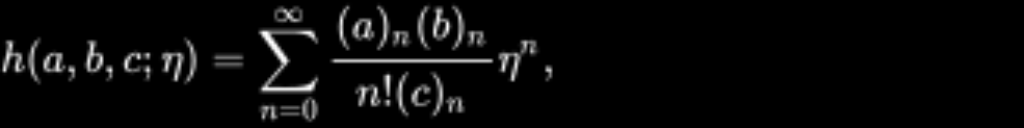

None

Predicted formula:
 <S> h ( a , b , c ; \eta ) = \sum _ { n = 0 } ^ { \infty } \frac { ( a ) _ { n } ( b ) _ { n } } { n ! ( c ) _ { n } } \eta ^ { n } , <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 569, 3)


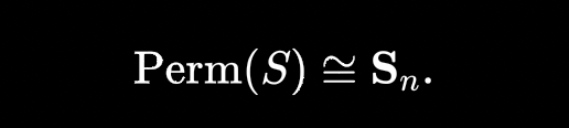

None
torch.Size([1, 128, 1024])


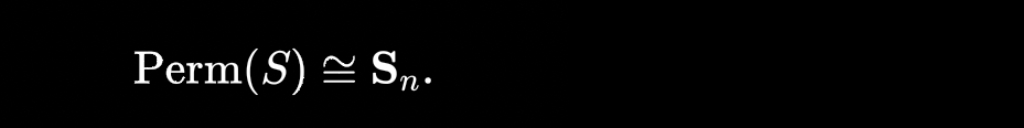

None

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 484, 3)


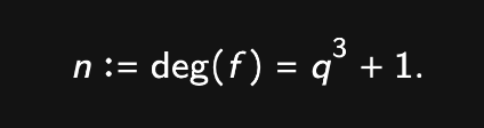

None
torch.Size([1, 128, 1024])


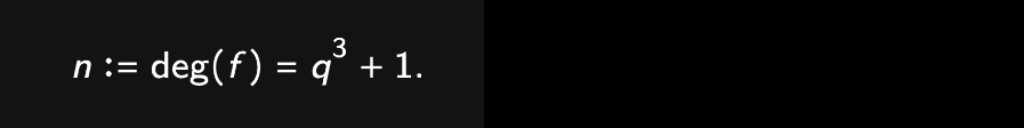

None

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) = c ^ { 3 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 554, 3)


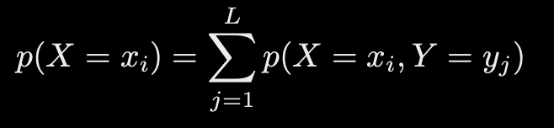

None
torch.Size([1, 128, 1024])


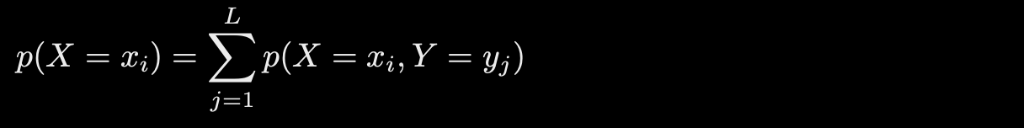

None

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 432, 3)


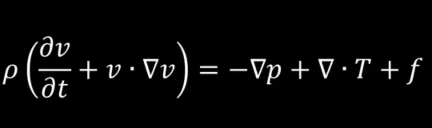

None
torch.Size([1, 128, 1024])


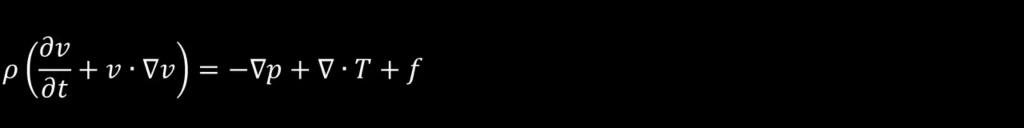

None

Predicted formula:
 <S> \rho \left( \frac { \partial \nu } { \partial t } + \nu \cdot \nabla v \right) = - \nabla p + \nabla \cdot T + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 911, 3)


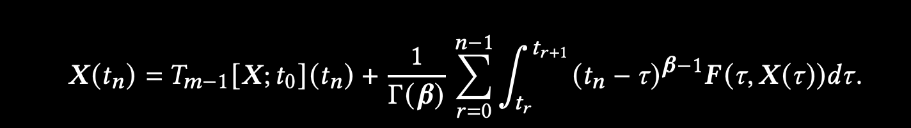

None
torch.Size([1, 128, 1024])


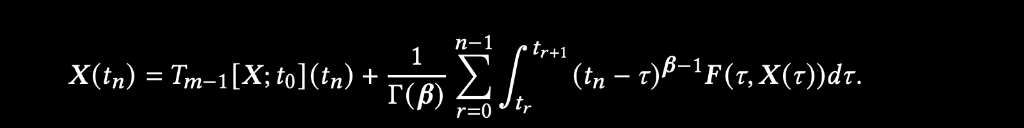

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) \star \frac { 1 } { \Gamma ( \rho ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { r } ^ { t r + 1 } ( t _ { n } - r ) ^ { \theta - 1 } F ( \tau , X ( \tau ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


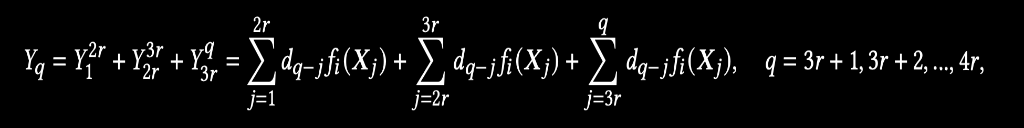

None
torch.Size([1, 128, 1024])


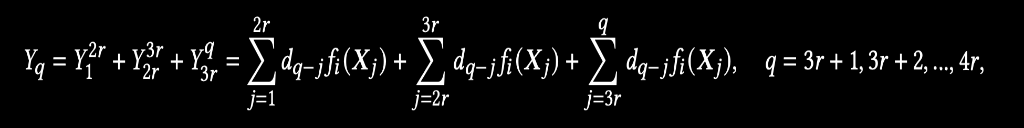

None

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } \cdot Y _ { 2 r } ^ { 3 r } \sim \prod _ { j = 1 } ^ { 2 r } d _ { q - j l } ( X _ { j } ) \star \sum _ { j = p } ^ { 2 r } d _ { q - j l } ( X _ { j } ) \star \sum _ { j = 2 r } ^ { q } d _ { q - j l } ( X _ { j } ) , \quad q = 3 r + 1 , 3 r + 2 , <E> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


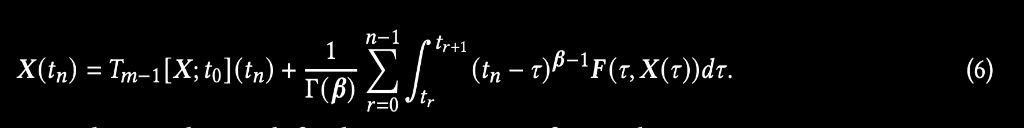

None
torch.Size([1, 128, 1024])


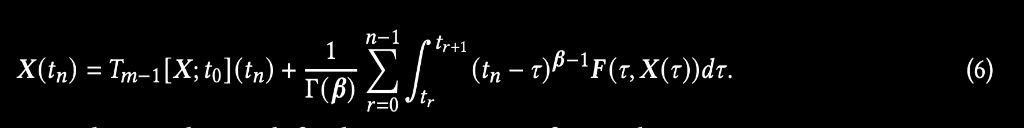

None

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) + \frac { 1 } { \Gamma ( \rho ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { r } ^ { r + 1 } f _ { r } ^ { r + 1 } ( t _ { n } - r ) ^ { \theta - 1 } F ( \tau _ { r } , X ( \tau ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 270, 3)


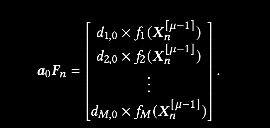

None
torch.Size([1, 128, 1024])


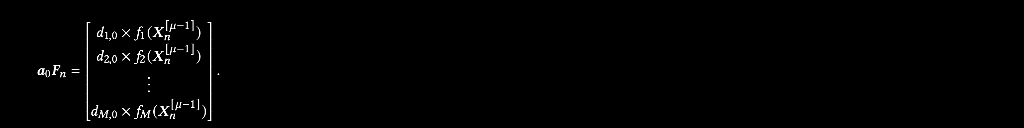

None

Predicted formula:
 <S> a _ { n } e _ { n } = \left[ \begin{array} { c c } { d x _ { n } ^ { ( n ) } } \\ { d x _ { n } ^ { ( n ) } } & { } \\ { d x _ { n } ^ { ( n ) } } \\ { d x _ { n } , \chi _ { n } ^ { ( n ) } } \\ \end{array} \right] <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 582, 3)


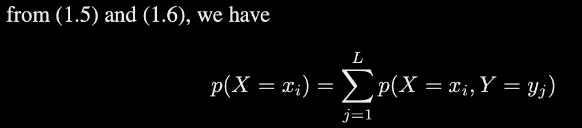

None
torch.Size([1, 128, 1024])


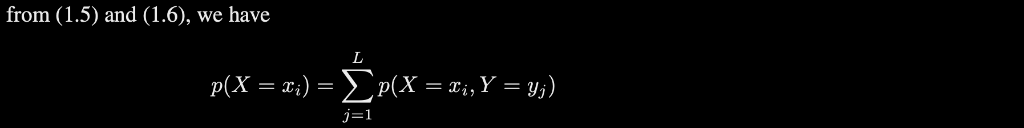

None

Predicted formula:
 <S> \begin{array} { l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l } { \mathrm { t r o l } } \\ { } & { p ( X = x _ { l } ) = \sum _ { l = 1 } ^ { l } p ( X = x _ { l } , Y = y _ { l } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


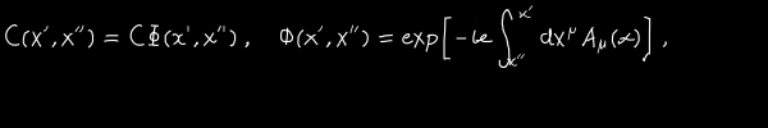

None
torch.Size([1, 128, 1024])


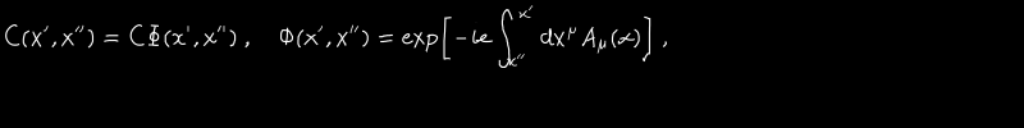

None

Predicted formula:
 <S> < \{ \zeta ^ { \prime } , \gamma ^ { \prime } \} = < \hat { E } ( \chi ^ { \prime } , \varphi ^ { \prime } \} \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \; \;


<IPython.core.display.Math object>

None
(128, 228, 3)


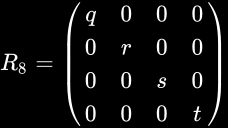

None
torch.Size([1, 128, 1024])


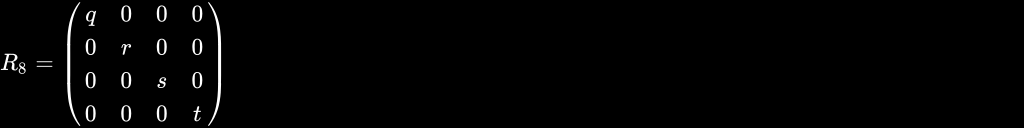

None

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c } { q } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ { 0 } & { 0 } & { 0 } & { 0 } \\ \end{array} \right) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


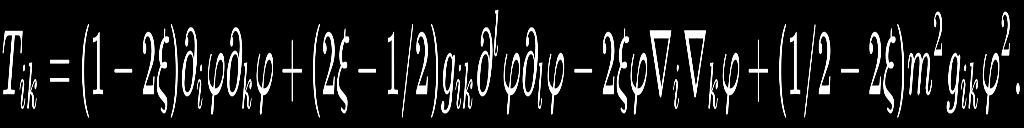

None
torch.Size([1, 128, 1024])


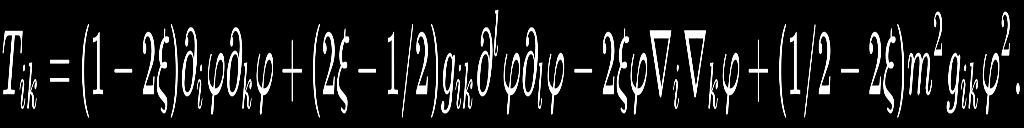

None

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi - 1 / 2 ) g _ { i k } \partial ^ { \mu } \varphi \partial _ { l } \varphi - 2 \xi \varphi \nabla _ { i } \nabla _ { k } \varphi + ( 1 / 2 - 2 \xi ) m ^ { 2 } g _ { j k } \varphi ^ { 2 } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 727, 3)


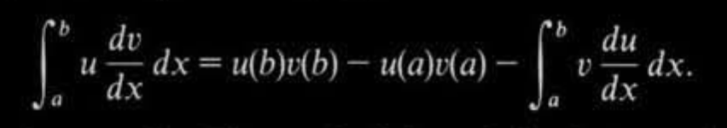

None
torch.Size([1, 128, 1024])


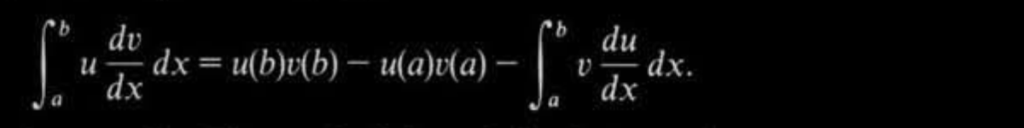

None

Predicted formula:
 <S> \int _ { a } ^ { a } \iota { \frac { d v } { d \chi } } d \chi = \iota ( b ) v ( b ) - \iota ( d ) v ( a ) - \int _ { a } ^ { a } v \, { \frac { d u } { d \chi } } } d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 949, 3)


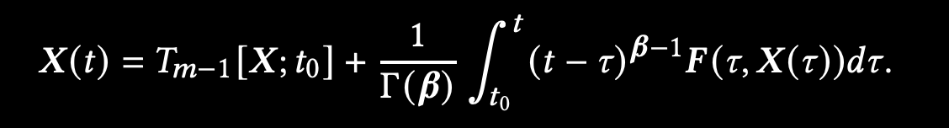

None
torch.Size([1, 128, 1024])


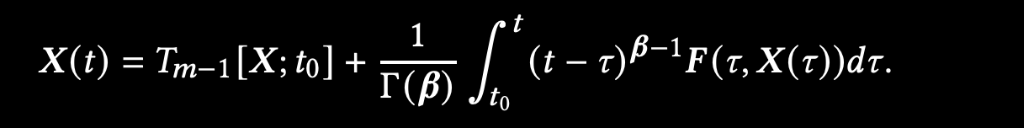

None

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] \star \frac { 1 } { \Gamma ( \rho ) } \int _ { t _ { 0 } } ^ { t } ( t - r ) ^ { g - 1 } F ( \tau , X ( \tau ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 270, 3)


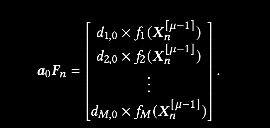

None
torch.Size([1, 128, 1024])


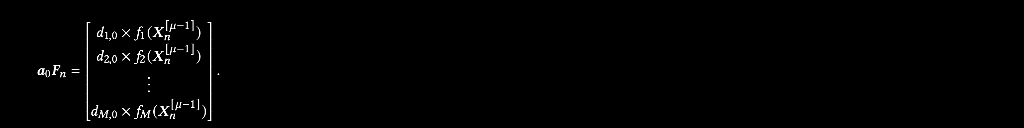

None

Predicted formula:
 <S> a _ { n } e _ { n } = \left[ \begin{array} { c c } { d x _ { n } ^ { ( n ) } } \\ { d x _ { n } ^ { ( n ) } } & { } \\ { d x _ { n } ^ { ( n ) } } \\ { d x _ { n } , \chi _ { n } ^ { ( n ) } } \\ \end{array} \right] <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


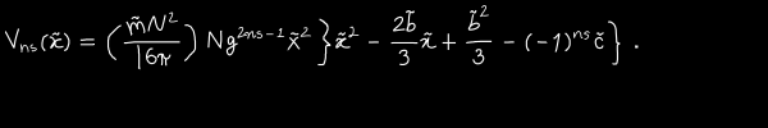

None
torch.Size([1, 128, 1024])


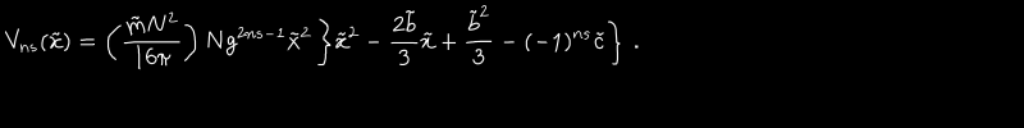

None

Predicted formula:
 <S> \psi _ { v , s } ( \tilde { x } ) = \left( \frac { \gamma _ { 0 } ^ { \infty } } { [ \Theta r } \right) \, \lambda y ^ { 2 s _ { v s t } - \frac { x } { 2 } \tilde { s } + \frac { x ^ { 2 } } { 2 } \tilde { s } + \frac { x ^ { 2 } } { 2 } - \, ( - \, ) ^ { r e } \epsilon \right] \, . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 768, 3)


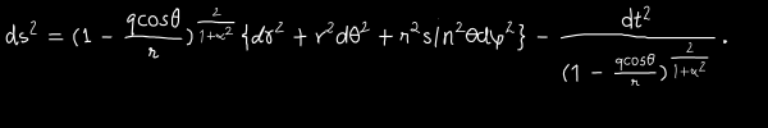

None
torch.Size([1, 128, 1024])


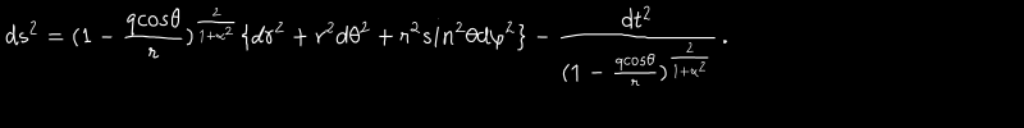

None

Predicted formula:
 <S> d s ^ { j } = ( 1 - \frac { 2 \xi \mathrm { e f e f } } { \bf e } ) ^ { 2 } + \varphi ^ { 2 } + \gamma ^ { 2 } \otimes n ^ { 2 } \xi | n ^ { 2 } - \frac { \mathrm { e f f f } ^ { 2 } } { 8 } | n ^ { 2 } - \frac { \mathrm { e f f } ^ { 2 } } { 8 } | + \frac { \mathrm { e f f } ^ { 2 } } { 8 } \rangle ^ { \frac { 1 } { 1 + \epsilon } } }


<IPython.core.display.Math object>

None
(128, 582, 3)


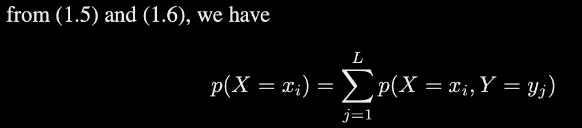

None
torch.Size([1, 128, 1024])


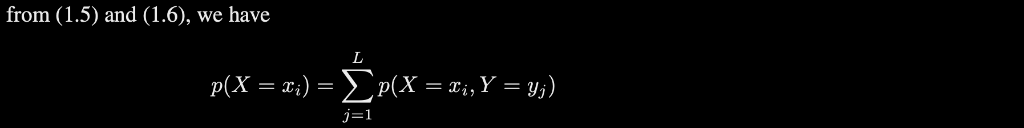

None

Predicted formula:
 <S> \begin{array} { l l l l l l l l l l l l l l l l l l l l l l l l l l l l l l } { \mathrm { t r o l } } \\ { } & { p ( X = x _ { l } ) = \sum _ { l = 1 } ^ { l } p ( X = x _ { l } , Y = y _ { l } ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


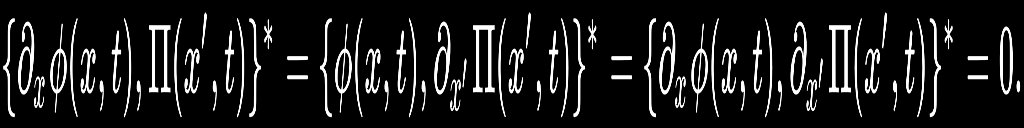

None
torch.Size([1, 128, 1024])


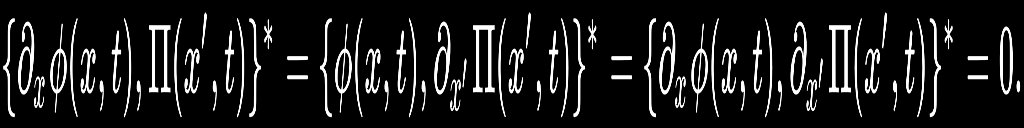

None

Predicted formula:
 <S> \{ \partial _ { x } \phi ( x , t ) , \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = \{ \partial _ { x } \phi ( x , t ) , \partial _ { x ^ { \prime } } \Pi ( x ^ { \prime } , t ) \} ^ { * } = 0 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


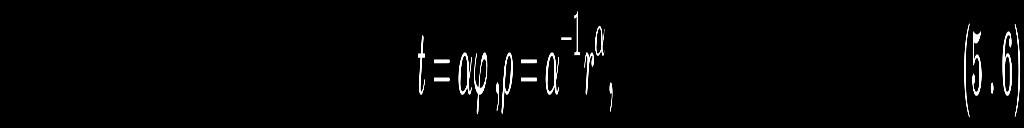

None
torch.Size([1, 128, 1024])


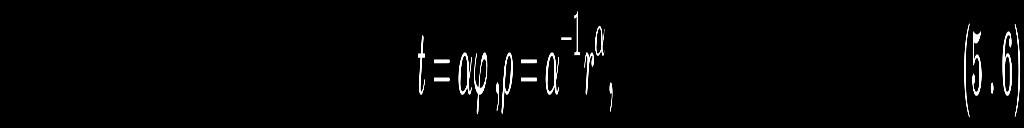

None

Predicted formula:
 <S> t = \alpha \varphi \, , \, \rho = \alpha ^ { - 1 } r ^ { \alpha } , \tag { 5 . 6 } <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 1024, 3)


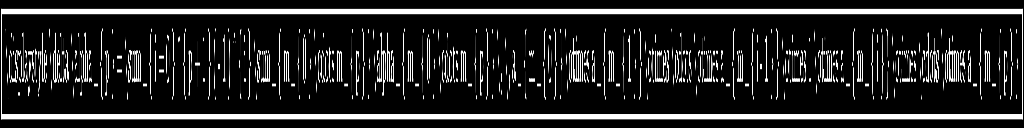

None
torch.Size([1, 128, 1024])


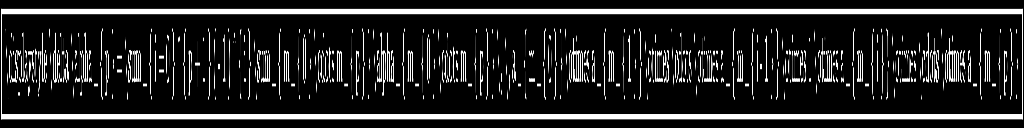

None

Predicted formula:
 <S> \fbox { { { 1 6 } \psi _ { 2 } , \cdots } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } & { 0 } \\ { 0 } \\ \end{matrix} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None


In [10]:
for image in IMAGES:
    predict(image)

(138, 410, 3)


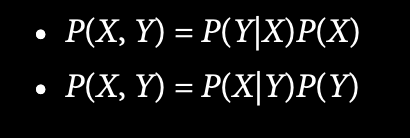

None
torch.Size([3, 138, 410])

Predicted formula:
 <S> \begin{array} { c l l l } { \cdot p ( X , Y ) = P ( Y ) P p ( X ) } \\ { \cdot P O ( X , Y ) = P ( X ) P Q ( Y ) } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(41, 178, 3)


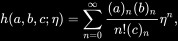

None
torch.Size([3, 41, 178])

Predicted formula:
 <S> \begin{array} { l l l l l l l l l l l l l l l l l r l } { ( u , v , v ) - \frac { 1 } { v } \frac { \lambda _ { 0 } , v , v , v ) - \frac { \lambda } { v _ { 0 } , v , v , v ) - \frac { \lambda } { v } \frac { \lambda u _ { 0 } , v , v , v , v ) - \frac { \lambda } { v } \frac { \lambda _ { 0 } } { v _ { 0 } , v , v , v , v ) - v _


<IPython.core.display.Math object>

None
(116, 516, 3)


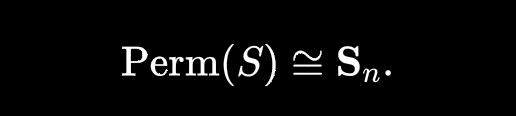

None
torch.Size([3, 116, 516])

Predicted formula:
 <S> \mathrm { P e r m } ( S ) \cong { \bf S } _ { n } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(112, 424, 3)


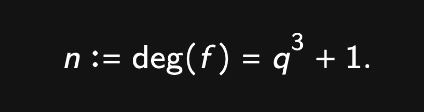

None
torch.Size([3, 112, 424])

Predicted formula:
 <S> n : = \mathrm { d e g } ( f ) = q ^ { 2 } + 1 . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 658, 3)


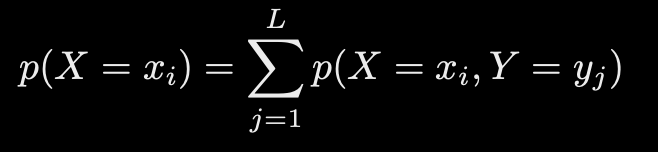

None
torch.Size([3, 152, 658])

Predicted formula:
 <S> p ( X = x _ { i } ) = \sum _ { j = 1 } ^ { L } p ( X = x _ { i } , Y = y _ { j } ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(320, 1080, 3)


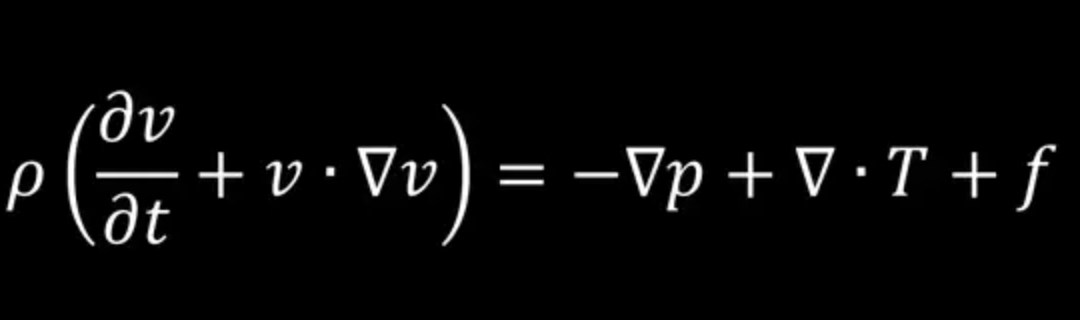

None
torch.Size([3, 320, 1080])

Predicted formula:
 <S> \rho \left( \frac { \partial v } { \partial t } + v \cdot \nabla v \right) = - \mathrm { V } p + \mathrm { V } \cdot T + f <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(200, 1424, 3)


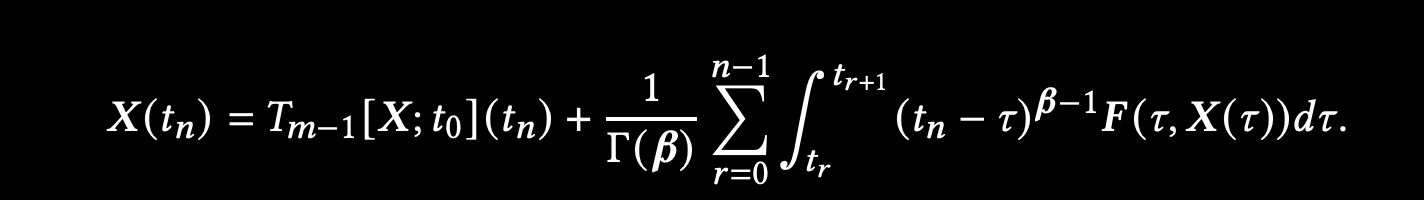

None
torch.Size([3, 200, 1424])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } \{ X ; t _ { 0 } \} ( t _ { n } ) * \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { t _ { r } } ^ { t _ { r + 1 } } ( t _ { n } - r ) ^ { \prime } f _ { r + 1 } ( t _ { n } - r ) ^ { \prime } f _ { r + 1 } ( t _ { n } - r ) } <E> <P> <P> <P>


<IPython.core.display.Math object>

None
(188, 1950, 3)


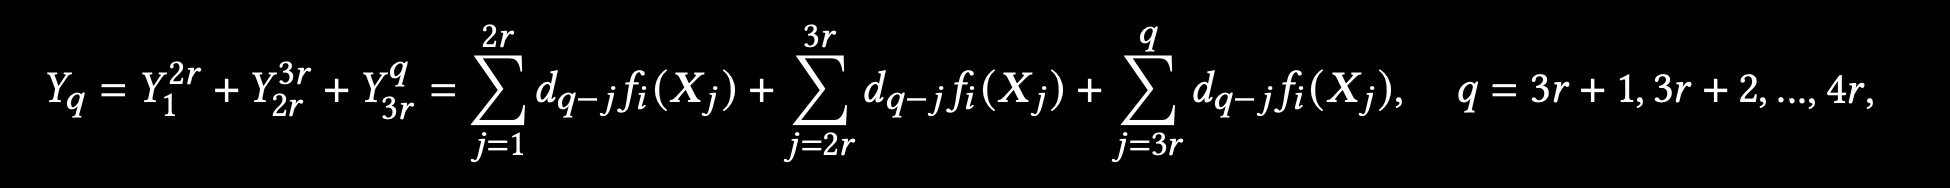

None
torch.Size([3, 188, 1950])

Predicted formula:
 <S> Y _ { q } = Y _ { 1 } ^ { 2 r } + Y _ { 2 r } ^ { s r } : Y _ { 3 r } ^ { q } = \sum _ { j = 1 } ^ { 2 r } d _ { q - j f } ( X _ { j } ) \star \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f } ( X _ { j } ) \star \sum _ { j = 2 r } ^ { 3 r } d _ { q - j f } ( X _ { j } ) } ) \star _


<IPython.core.display.Math object>

None
(202, 1774, 3)


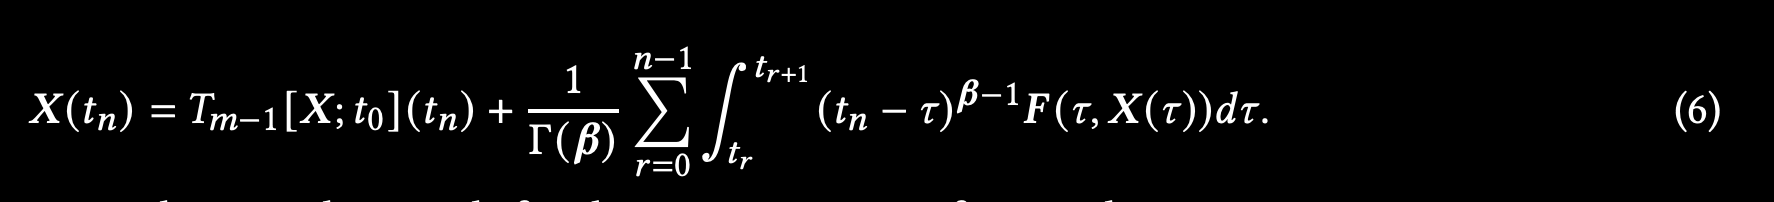

None
torch.Size([3, 202, 1774])

Predicted formula:
 <S> X ( t _ { n } ) = T _ { m - 1 } [ X ; t _ { 0 } ] ( t _ { n } ) \star \frac { 1 } { \Gamma ( \theta ) } \sum _ { r = 0 } ^ { n - 1 } \int _ { r } ^ { t _ { r + 1 } } ( t _ { n } - r ) ^ { \rho - 1 } f _ { r } } ^ { t _ { r + 1 } ( t _ { n } - r ) ^ { \rho } . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


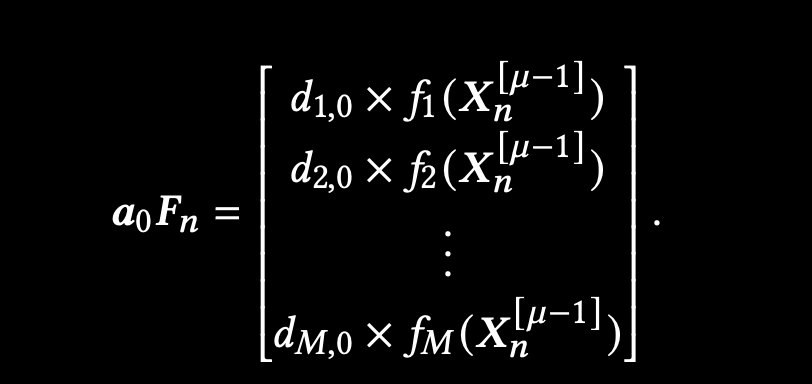

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { l l l l l l l l l } { a _ { 0 } F _ { 1 , 0 } ^ { [ \mu - 1 ] } \\ \end{array} } \\ { d _ { 2 , O } \times f _ { 2 } ( X _ { n } ^ { [ \mu - 1 ] } } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(224, 1020, 3)


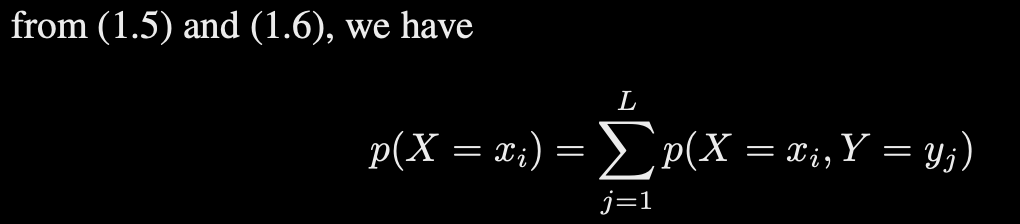

None
torch.Size([3, 224, 1020])

Predicted formula:
 <S> \mathrm { f r o m } \, ( 1 , 5 ) \, \mathrm { a n d } \, ( 1 . 6 ) , \, \mathrm { w e ~ h a v e } } \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad \qquad


<IPython.core.display.Math object>

None
(100, 600, 3)


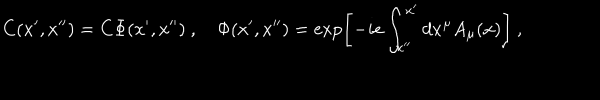

None
torch.Size([3, 100, 600])

Predicted formula:
 <S> \begin{array} { c c c } { < \{ \chi , \chi ^ { \prime } \} = < \hat { \xi } ( \chi , x ^ { \prime } ) > } & { q ( \varphi , \chi ^ { \prime } ) = e _ { \psi } [ - \omega \sum _ { \mu } ^ { \prime } \omega ^ { \prime } , t ^ { \prime } \} } \\ { } & { } & { } & { q ( \varphi , \chi ^ { \prime } ) = e _ { \psi } [ - \omega \sum _ { \mu } ^ { \prime } } \\ { 0 } \\ \end{array} <E> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(128, 228, 3)


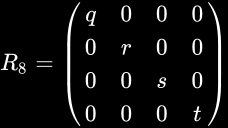

None
torch.Size([3, 128, 228])

Predicted formula:
 <S> R _ { 8 } = \left( \begin{array} { c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c


<IPython.core.display.Math object>

None
(128, 3260, 3)


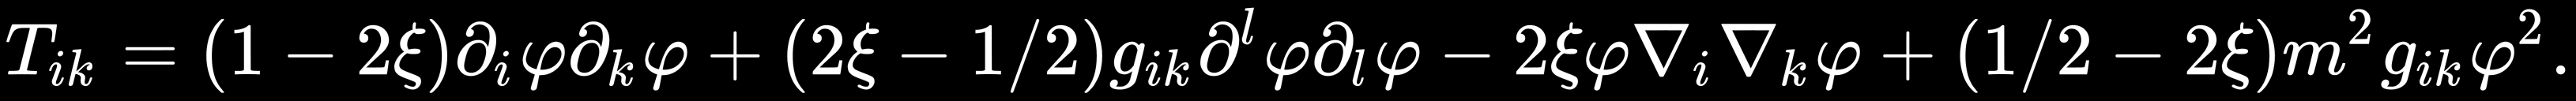

None
torch.Size([3, 128, 3260])

Predicted formula:
 <S> T _ { i k } = ( 1 - 2 \xi ) \partial _ { i } \varphi \partial _ { k } \varphi + ( 2 \xi \partial _ { k } \varphi + ( 2 \xi + ( 2 \xi ) <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(150, 852, 3)


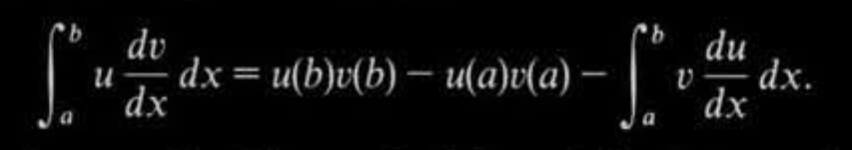

None
torch.Size([3, 150, 852])

Predicted formula:
 <S> \left\{ \begin{array} { l l l l l } { a } & { d v } \\ { a } & { d \chi } \\ \end{array} \right. d \chi = u ( b ) v ( d ) - \iota ( d ) v ( d ) - \int _ { a } ^ { b } v \, \frac { d u } { d \chi } \, d \chi . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(152, 1128, 3)


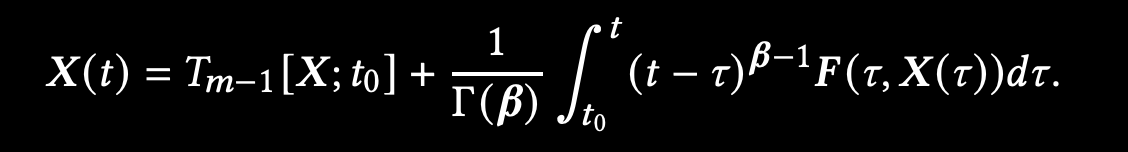

None
torch.Size([3, 152, 1128])

Predicted formula:
 <S> X ( t ) = T _ { m - 1 } [ X ; t _ { 0 } ] \star \frac { 1 } { \Gamma ( \theta ) } \int _ { t _ { 0 } } ^ { t } ( t - r ) ^ { g - 1 } F ( \tau , X ( \tau ) ) d \tau . <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(384, 812, 3)


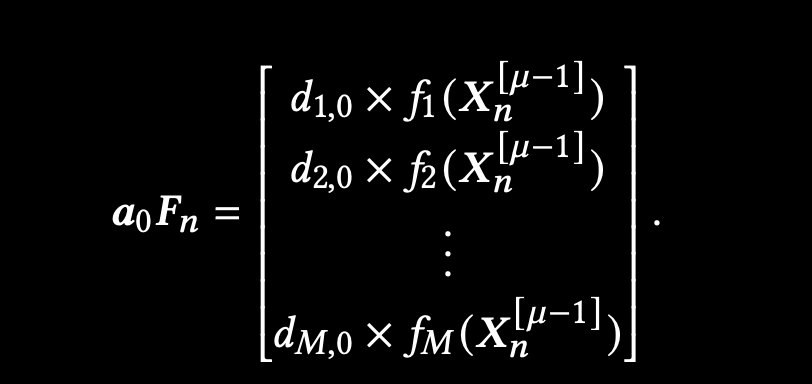

None
torch.Size([3, 384, 812])

Predicted formula:
 <S> \begin{array} { l l l l l l l l l } { a _ { 0 } F _ { 1 , 0 } ^ { [ \mu - 1 ] } \\ \end{array} } \\ { d _ { 2 , O } \times f _ { 2 } ( X _ { n } ^ { [ \mu - 1 ] } } \\ \end{array} <E> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P> <P>


<IPython.core.display.Math object>

None
(100, 600, 3)


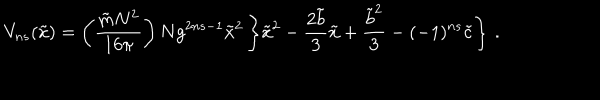

In [ ]:
for image in IMAGES:
    predict_simple(image)

In [ ]:
for image in IMAGES:
    predict_scaled(image)